# Lead-lag relationships between alt-BTC and stock-crypto pairings


# Abstract 


We thought Bitcoin price movements would lead to similar price movements in altcoins. Investors are most confident in Bitcoin as the least risky crypto. For example, imagine a crypto bear market. As Bitcoin recovers, investors gain confidence to put money in riskier coins so as a result, altcoins may lag behind Bitcoin by a certain amount of time. We wanted to perform cross correlation to find that shift. 

However, using cross correlation, we found the max correlation with a timeshift of zero using 1 minute and 1 day data spanning multiple years. However, we found that on certain days, there are clear lead-lag relationships between BTC and other altcoins or stocks. To this, we developed a trading strategy that capitalizes on these correlations using Linear Regression slope differences as our entry and exit signals.


# Introduction:

We started with the intent of exploring the relationship between cryptocurrencies. In particular, we expected bitcoin to be a leading indicator of altcoins as it is the largest and most popular crypto. However, we quickly realized that to be minimal, if any. Hence, we shifted to a correlation between crypto assets and stock primarily. Our goal was to be able to trade off of a shift in some indicator that we identify early in the day between a set of possible indicators and assets that can follow those. 



In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.linear_model import LinearRegression

In [3]:
# Get the data
qqq = yf.download(tickers="QQQ", period="2d", interval="1m")
btc = yf.download(tickers="BTC-USD", period="2d", interval="1m")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
df = qqq.merge(btc,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_qqq","_btc"])
print(df.tail())

                             Open_qqq    High_qqq     Low_qqq   Close_qqq  \
Datetime                                                                    
2022-04-29 15:55:00-04:00  313.109985  313.420013  312.899994  313.100006   
2022-04-29 15:56:00-04:00  313.089996  313.239990  312.809998  312.940002   
2022-04-29 15:57:00-04:00  312.940002  312.940002  312.649994  312.747009   
2022-04-29 15:59:00-04:00  312.940002  313.559998  312.600006  313.239990   
2022-04-29 16:00:00-04:00  313.250000  313.250000  313.250000  313.250000   

                           Adj Close_qqq  Volume_qqq      Open_btc  \
Datetime                                                             
2022-04-29 15:55:00-04:00     313.100006     1012163  38235.535156   
2022-04-29 15:56:00-04:00     312.940002      665858  38236.656250   
2022-04-29 15:57:00-04:00     312.747009      854921  38260.964844   
2022-04-29 15:59:00-04:00     313.239990     2119364  38301.105469   
2022-04-29 16:00:00-04:00     313.250000

In [5]:
y1 = df['Close_qqq']
y2 = df['Close_btc']
y1 = (y1 - np.mean(y1)) / np.std(y1)
y2 = (y2 - np.mean(y2)) / np.std(y2)

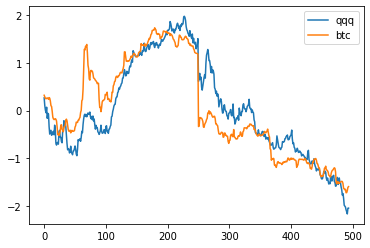

In [6]:
plt.plot(range(len(y1)),y1, label="qqq")
plt.plot(range(len(y2)),y2, label="btc")
plt.legend()

# EDA 

We looked at BTC and QQQ 5 day price histories to see if they were correlated. They indeed looked correlated. We then normalized the closing prices and performed cross correlation and found BTC to be ahead of QQQ by a number of minutes. We then applied that shift to the price chart.

In [65]:
def max_offset(df1, df2):
#     print(len(df1), len(df2))
    corrs = signal.correlate(df1, df2, mode='full')
    return np.argmax(corrs) - len(df1) + 1, corrs[np.argmax(corrs)]
print(max_offset(y1,y2))

(0, 4657.263934995171)


In [ ]:
global_period = "1d"
global_interval = "1m"

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


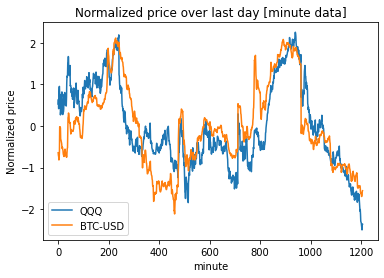

(0, 946.4194546463453)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


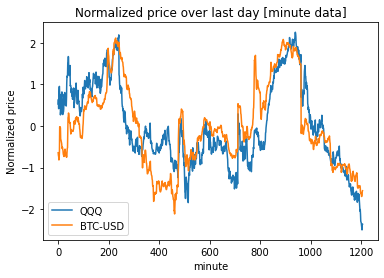

0       0.527238
1       0.638272
2       0.416230
3       0.813154
4       0.935293
          ...   
1201   -2.401316
1202   -2.445731
1203   -2.499304
1204   -2.362458
1205   -2.359680
Name: Close_a, Length: 1206, dtype: float64 0      -0.642669
1      -0.705889
2      -0.737525
3      -0.817434
4      -0.768994
          ...   
1201   -1.695561
1202   -1.693479
1203   -1.648346
1204   -1.573819
1205   -1.556848
Name: Close_b, Length: 1206, dtype: float64
(0, 46216.12912316974, [(0.003312828682910043, 0), (0.010361012023485827, 15), (0.027814768926969637, 30), (0.022865170454147123, 45), (0.008536417029482095, 60), (0.008075500805114115, 75), (0.010451413964966984, 90), (0.019641892144205225, 105), (0.009472031991638732, 120), (0.003665410210419343, 135), (0.008744879699222606, 150), (0.014656485337404171, 165), (0.054979393520618564, 180), (0.0002175704849556731, 195), (0.0007731330676298692, 210), (0.03842025890947595, 225), (0.01989292295326676, 240), (0.0003647251834550391, 255),

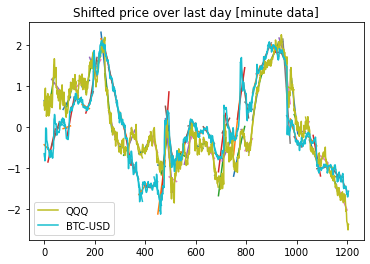

In [67]:
def ticker_offset(str1, str2, silent=False):
    a = yf.download(tickers=str1, period=global_period, interval=global_interval)
    b = yf.download(tickers=str2, period=global_period, interval=global_interval)
    df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_a","_b"])
    y1 = df['Close_a']
    y2 = df['Close_b']
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    if not silent:
        plt.plot(range(len(y1)),y1, label=str1)
        plt.plot(range(len(y2)),y2, label=str2)
        plt.legend()
        plt.title("Normalized price over last day [minute data]")
        plt.ylabel("Normalized price")
        plt.xlabel("minute")
        plt.show()
    return max_offset(y1,y2)

def ticker_offset_slope_loss(str1, str2, silent=False):
    a = yf.download(tickers=str1, period=global_period, interval=global_interval)
    b = yf.download(tickers=str2, period=global_period, interval=global_interval)
    df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_a","_b"])
    y1 = df['Close_a']
    y2 = df['Close_b']
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    if not silent:
        plt.plot(range(len(y1)),y1, label=str1)
        plt.plot(range(len(y2)),y2, label=str2)
        plt.legend()
        plt.title("Normalized price over last day [minute data]")
        plt.ylabel("Normalized price")
        plt.xlabel("minute")
        plt.show()
    offset = max_offset(y1,y2)[0]
    b["Datetime_shift"] = b.index + pd.Timedelta(minutes=offset)
    shift_df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime_shift", suffixes=["_a","_b"])
    y1 = shift_df['Close_a']
    y2 = shift_df['Close_b']
    y1_original = y1[:]
    y2_original = y2[:]
    
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    print(y1, y2)
    f, ax = plt.subplots()
    def slope_loss(k, s):
        diffs = []
        for i in range(0, len(y1)-k, s):
            xs = np.array(range(i, i+k)).reshape(-1, 1)
            line1 = LinearRegression().fit(xs, y1[i:i+k])
            starty = line1.predict([xs[0]])
            endy = line1.predict([xs[-1]])
            ax.plot([xs[0], xs[-1]], [starty, endy])
            reg1 = line1.coef_[0]
            #print("Slope 1 ", reg1)
            line2 = LinearRegression().fit(xs, y2[i:i+k])
            reg2 = line2.coef_[0]
            starty = line2.predict([xs[0]])
            endy = line2.predict([xs[-1]])
            ax.plot([xs[0], xs[-1]], [starty, endy])
            #print("Slope 2", reg2)
#             print(type(xs[0]))
            diffs.append((abs(reg1-reg2), list(xs[0])[0]))
#             if i*s < len(y1)-k: 
#                 print(shift_df.iloc[i * s, :])
#         print(np.where(shift_df[shift_df[]))

        #print(diffs)
        return np.sum(diffs), diffs
        
    total_slope_loss, diffs = slope_loss(30, 15)
    if not silent:
        ax.plot(range(len(y1)),y1, label=str1)
        ax.plot(range(len(y2)),y2, label=str2)
        ax.legend()
        ax.set_title("Shifted price over last day [minute data]")
        #ax.ylabel("Normalized price")
        #ax.xlabel("minute")
        #ax.show()
    return offset, total_slope_loss, diffs, y1_original, y2_original
print(ticker_offset("QQQ","BTC-USD"))
print(ticker_offset_slope_loss("QQQ","BTC-USD")[:3])



# Methods

We realized an issue of cross-correlation is that it is influenced a lot by magnitudes. We care a lot more about the slopes.

Our idea: SLOPE LOSS. Use the difference in slopes of the regression line in the loss function. Hyperparameters: stride of slope intervals, length of slope interval.

Our trading strategy is as such: wait for the first half of the day until we have enough bars and perform cross correlation to find a the time shift. If such a shift exists, use the shift to trade. If the difference in slopes is greater than a predefined threshold (hyperparameter), and the asset that is leading has the greater slope, then buy. Do the same but in the downwards direction for selling.  

In [146]:
## Early ticker offset does not plot and only uses the 
# first half of the data to find the shift for correlation
from datetime import timedelta
global_interval = "1m"

def early_ticker_offset(str1, str2, start_date):
    start_ts = pd.Timestamp(start_date)
    end_ts = start_ts + timedelta(days=1)
    end_date = str(end_ts).split()[0]
    a = yf.download(tickers=str1, interval=global_interval, start=start_date, end=end_date, progress=False)
    b = yf.download(tickers=str2, interval=global_interval, start=start_date, end=end_date, progress=False)
    df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_a","_b"])
    
    ## Use only the first half of the day
    df = df[:len(df)//2]
    y1 = df['Close_a']
    y2 = df['Close_b']
    y1_original = y1[:]
    y2_original = y2[:]
    
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)

    offset = max_offset(y1,y2)[0]
    b["Datetime_shift"] = b.index + pd.Timedelta(minutes=offset)
    shift_df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime_shift", suffixes=["_a","_b"])
    y1 = shift_df['Close_a'][:len(df)//2]
    y2 = shift_df['Close_b'][:len(df)//2]
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    
    def slope_loss(k, s):
        diffs = []
        for i in range(0,len(y1)-k, s):
            xs = np.array(range(i,i+k)).reshape(-1, 1)
            line1 = LinearRegression().fit(xs, y1[i:i+k])
            starty = line1.predict([xs[0]])
            endy = line1.predict([xs[-1]])

            reg1 = line1.coef_[0]
            #print("Slope 1 ", reg1)
            line2 = LinearRegression().fit(xs, y2[i:i+k])
            reg2 = line2.coef_[0]
            starty = line2.predict([xs[0]])
            endy = line2.predict([xs[-1]])

            #print("Slope 2", reg2)
            diffs.append((abs(reg1-reg2), list(xs[0])[0]))
        #print(diffs)
        return np.sum(diffs), diffs
        
    total_slope_loss, diffs = slope_loss(30, 15)
    return offset, total_slope_loss, diffs, y1_original, y2_original

def backtest_one_day(date_str):
    token_diffs = {}
    y1y2_original = {}
    tokens = ["QQQ", "BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD", "LUNA1-USD", "ADA-USD", "ALGO-USD", "XRP-USD", "LUNA1-USD", "ADA-USD", "HEX-USD", "AVAX-USD", "DOGE-USD"] # 
    offset_matrix = {}

    for idx1, token1 in enumerate(tokens):
        for idx2, token2 in enumerate(tokens):
            if token1 == token2: 
                continue
            offset, sl, diffs, y1, y2 = early_ticker_offset(token1, token2, date_str)
            pair_symbol = token1 + token2
    #         print(pair_symbol)
            offset_matrix[pair_symbol] = offset
            token_diffs[pair_symbol] = diffs
            y1y2_original[pair_symbol] = (y1, y2)
    #         print(offset_matrix, token_diffs, y1y2_original)
            ##filter for time shifts that make sense and that we can use
            # 15min shift is the limit we picked, and <0 so we can use it to trade
            # if -15<offset<0:
            #     print(token1, token2, offset, "slope loss", sl, diffs)
    
    trading_trigger_threshold = 0.01
    pair_symbols = offset_matrix.keys()
    pnls = []
    pnls_dict = {}
    all_trades = []
    trades_dict = {}
    for pair_symbol in pair_symbols:
        offset = offset_matrix[pair_symbol] 
        diffs = token_diffs[pair_symbol]  
        y1_original, y2_original = y1y2_original[pair_symbol]    
        # print(f"Starting {pair_symbol}")
        pnl = 0
        hold = False
        enter_price = 0
        for i in range(len(diffs)-1):
            if diffs[i+1][0] - diffs[i][0] > trading_trigger_threshold and hold is False: # and diffs[i+1][1]+offset < max_timestamp: # buy
                # pnl -= y2_original[diffs[i+1][1]]
                hold = True
                enter_price = y2_original[diffs[i+1][1]]
                # print(f"Buy @ {y2_original[diffs[i+1][1]]:.4f} | P/L: {pnl}")
            elif diffs[i][0] - diffs[i+1][0] > trading_trigger_threshold and hold is True: # and diffs[i+1][1]+offset < max_timestamp: # sell
                exit_price = y2_original[diffs[i+1][1]]
                result = 100*(exit_price - enter_price) / enter_price
                pnl += result
                all_trades.append(result)
                pair_trades = trades_dict.get(pair_symbol, [])
                pair_trades.append(result)
                trades_dict[pair_symbol] = pair_trades
                hold = False
                # print(f"Sell @ {y2_original[diffs[i+1][1]]:.4f} | P/L: {pnl}")
        if hold:
            exit_price = y2_original[diffs[-1][1]]
            result = 100*(exit_price - enter_price) / enter_price
            pnl += result
            all_trades.append(result)
            pair_trades = trades_dict.get(pair_symbol, [])
            pair_trades.append(result)
            trades_dict[pair_symbol] = pair_trades
            hold = False
            # print(f"Sell @ {y2_original[diffs[-1][1]]:.4f} | P/L: {pnl}")
        pnls.append(pnl)
        pnls_dict[pair_symbol] = pnls_dict.get(pair_symbol, 0) + pnl
        # print(f"Ending {pair_symbol} | P/L %: {pnl:.2f}")
    pair_symbols = offset_matrix.keys()
    return ([*pair_symbols], pnls, pnls_dict, all_trades, trades_dict)
    # plt.figure(figsize=(25, 15))
    # plt.bar(pair_symbols, pnls)
    # plt.title("Our Strategy's P/L Percent for Each Pairing Traded")
    # plt.xlabel("Pairing Traded")
    # plt.ylabel("P/L %")
    # plt.xticks(rotation='vertical')
    # plt.show()




In [119]:
def plot_results(pair_symbols, pnls):
    plt.figure(figsize=(25, 15))
    plt.bar(pair_symbols, pnls)
    plt.title("Our Strategy's P/L Percent for Each Pairing Traded")
    plt.xlabel("Pairing Traded")
    plt.ylabel("P/L %")
    plt.xticks(rotation='vertical')
    plt.show()
    
# symbols, pnls, pnls_dict, all_trades, trades_dict = backtest_one_day("2022-04-29")
# plot_results(symbols, pnls)

In [120]:
def stats(trades, name):
    def sub_stats(trades, name):
        if not len(trades):
            return
        avg = np.mean(trades)
        sd = np.std(trades)
        print(f"{name} | Avg Trade {avg:.2f}% | SD {sd:.2f}%")
    
    wins = trades[trades > 0]
    losses = trades[trades < 0]
    scratch = trades[trades == 0]
    if not len(trades) or len(scratch) == len(trades):
        return
    print(f"{name} | Total P/L % :: {np.sum(trades):.2f}%")
    print(f"Winrate {100*len(wins) / (len(trades) - len(scratch)):.2f}% | {len(trades)} Trades, {len(wins)} Winners, {len(losses)} Losers, {len(scratch)} Breakeven")
    sub_stats(trades, "All Trades")
    sub_stats(wins, "Winners")
    sub_stats(losses, "Losers")
    print(f"Profit Factor: {abs(np.sum(wins) / np.sum(losses))} | Gross Profit: {np.sum(wins):.2f}% | Gross Loss: {np.sum(losses):.2f}%")

In [ ]:
history = {}

In [157]:
#Earliest is 30 days before current day
starting_date = "2022-04-16"
delt = timedelta(days=1)
current_date = pd.Timestamp(starting_date)
for i in range(17):
    cur_date_str = str(current_date).split()[0]
    if current_date.weekday() >= 5:
        #Ignore Saturday and Sunday if QQQ is included
        print(f"Ignoring {cur_date_str}")
        current_date += delt
        continue
    history[cur_date_str] = backtest_one_day(cur_date_str)
    print("Done with",cur_date_str)
    current_date += delt
list(history.keys())


Ignoring 2022-04-16
Ignoring 2022-04-17
Done with 2022-04-18
Done with 2022-04-19
Done with 2022-04-20
Done with 2022-04-21
Done with 2022-04-22
Ignoring 2022-04-23
Ignoring 2022-04-24
Done with 2022-04-25
Done with 2022-04-26
Done with 2022-04-27


In [148]:
def get_most_profitable_tickers(n, symbs, pnls):
    inds = np.argsort(-np.array(pnls))
    best = []
    for i in range(n):
        ind = inds[i]
        print(f"{symbs[ind]} | {pnls[ind]:.2f}")
        best.append(symbs[ind])
    return best

def get_least_profitable_tickers(n, symbs, pnls):
    inds = np.argsort(np.array(pnls))
    best = []
    for i in range(n):
        ind = inds[i]
        print(f"{symbs[ind]} | {pnls[ind]:.2f}")
        best.append(symbs[ind])
    return best

In [149]:
first_index = list(history.keys())[0]
all_pairings = history[first_index][0]
all_trades = []
all_pnls = np.zeros(len(history[first_index][1]))
for _, pnls, _, trades, _ in history.values():
    all_trades += trades
    all_pnls += np.array(pnls)
all_trades = np.array(all_trades)
stats(all_trades, "All Trades (past 30 days)")
print("----------")
print("----------")


All Trades (past 30 days) | Total P/L % :: 80.52%
Winrate 49.93% | 3321 Trades, 1535 Winners, 1539 Losers, 247 Breakeven
All Trades | Avg Trade 0.02% | SD 0.43%
Winners | Avg Trade 0.33% | SD 0.36%
Losers | Avg Trade -0.28% | SD 0.28%
Profit Factor: 1.1869410222759056 | Gross Profit: 511.25% | Gross Loss: -430.73%
----------
----------


In [154]:
for day in history.keys():
    _, pnls, pnls_dict, trades, trades_dict = history[day]
    stats(np.array(trades), day)
    print("-------------------------")

2022-04-01 | Total P/L % :: 56.01%
Winrate 69.17% | 283 Trades, 184 Winners, 82 Losers, 17 Breakeven
All Trades | Avg Trade 0.20% | SD 0.44%
Winners | Avg Trade 0.41% | SD 0.38%
Losers | Avg Trade -0.24% | SD 0.23%
Profit Factor: 3.828896836672182 | Gross Profit: 75.80% | Gross Loss: -19.80%
-------------------------
2022-04-04 | Total P/L % :: 10.02%
Winrate 47.02% | 334 Trades, 142 Winners, 160 Losers, 32 Breakeven
All Trades | Avg Trade 0.03% | SD 0.39%
Winners | Avg Trade 0.33% | SD 0.39%
Losers | Avg Trade -0.23% | SD 0.19%
Profit Factor: 1.2686606451548943 | Gross Profit: 47.34% | Gross Loss: -37.31%
-------------------------
2022-04-05 | Total P/L % :: -21.79%
Winrate 39.55% | 380 Trades, 140 Winners, 214 Losers, 26 Breakeven
All Trades | Avg Trade -0.06% | SD 0.32%
Winners | Avg Trade 0.18% | SD 0.22%
Losers | Avg Trade -0.22% | SD 0.29%
Profit Factor: 0.5357675009090516 | Gross Profit: 25.15% | Gross Loss: -46.95%
-------------------------
2022-04-06 | Total P/L % :: -25.07%
W

In [150]:
best_pairs = get_most_profitable_tickers(15, all_pairings, all_pnls)


BTC-USDALGO-USD | 6.20
BTC-USDADA-USD | 5.35
LUNA1-USDAVAX-USD | 5.00
LUNA1-USDHEX-USD | 4.68
BNB-USDHEX-USD | 4.19
HEX-USDDOGE-USD | 4.13
XRP-USDALGO-USD | 4.09
BTC-USDDOGE-USD | 3.89
ALGO-USDHEX-USD | 3.80
QQQAVAX-USD | 3.39
AVAX-USDHEX-USD | 3.13
AVAX-USDADA-USD | 3.04
HEX-USDADA-USD | 2.97
DOGE-USDADA-USD | 2.90
ETH-USDHEX-USD | 2.84


In [151]:
worst_pairs = get_least_profitable_tickers(15, all_pairings, all_pnls)

ALGO-USDAVAX-USD | -3.68
ADA-USDLUNA1-USD | -3.10
ETH-USDLUNA1-USD | -2.92
ADA-USDXRP-USD | -2.45
DOGE-USDXRP-USD | -2.35
ALGO-USDDOGE-USD | -2.25
BNB-USDAVAX-USD | -2.07
ALGO-USDLUNA1-USD | -1.75
ADA-USDALGO-USD | -1.65
HEX-USDXRP-USD | -1.59
QQQALGO-USD | -1.55
ALGO-USDADA-USD | -1.44
QQQDOGE-USD | -1.24
ADA-USDDOGE-USD | -1.24
ETH-USDXRP-USD | -1.15


### Our trading strategy is simply comparing ith and (i+1)th slope, if the upwards and downwards diff is greater than a certain threshold, then we buy/sell y2 at the (i+1 timestamp + offset). Given we have already shifted the timestamp and joined both crypto dataframes, I just use y2's y2_original[diffs[i+1][1]] for buy and sell. 

### We paid extra attention to data leackage, i.e. not using future knowledge to trade the current stock


## Results

After backtesting 30 days of 1min data, we found the following results.



Starting QQQBTC-USD
Buy @ 39004.6758 | P/L: 0
Sell @ 39004.1328 | P/L: -0.001392060667405961
Buy @ 39734.5547 | P/L: -0.001392060667405961
Sell @ 39288.2695 | P/L: -1.1245584325064637
Ending QQQBTC-USD | P/L %: -1.12
Starting QQQETH-USD
Buy @ 2864.4902 | P/L: 0
Sell @ 2864.5664 | P/L: 0.0026591773323542105
Buy @ 2895.4849 | P/L: 0.0026591773323542105
Sell @ 2903.5049 | P/L: 0.27964282290256365
Ending QQQETH-USD | P/L %: 0.28
Starting QQQBNB-USD
Buy @ 398.0031 | P/L: 0
Sell @ 397.6360 | P/L: -0.09221145237714776
Buy @ 401.2162 | P/L: -0.09221145237714776
Sell @ 401.2162 | P/L: -0.09221145237714776
Ending QQQBNB-USD | P/L %: -0.09
Starting QQQXRP-USD
Buy @ 0.6370 | P/L: 0
Sell @ 0.6375 | P/L: 0.08722929279800636
Buy @ 0.6430 | P/L: 0.08722929279800636
Sell @ 0.6404 | P/L: -0.3169105332597379
Ending QQQXRP-USD | P/L %: -0.32
Starting QQQLUNA1-USD
Buy @ 89.6320 | P/L: 0
Sell @ 88.9289 | P/L: -0.7844149003676889
Buy @ 88.3944 | P/L: -0.7844149003676889
Sell @ 89.0759 | P/L: -0.0134778321916

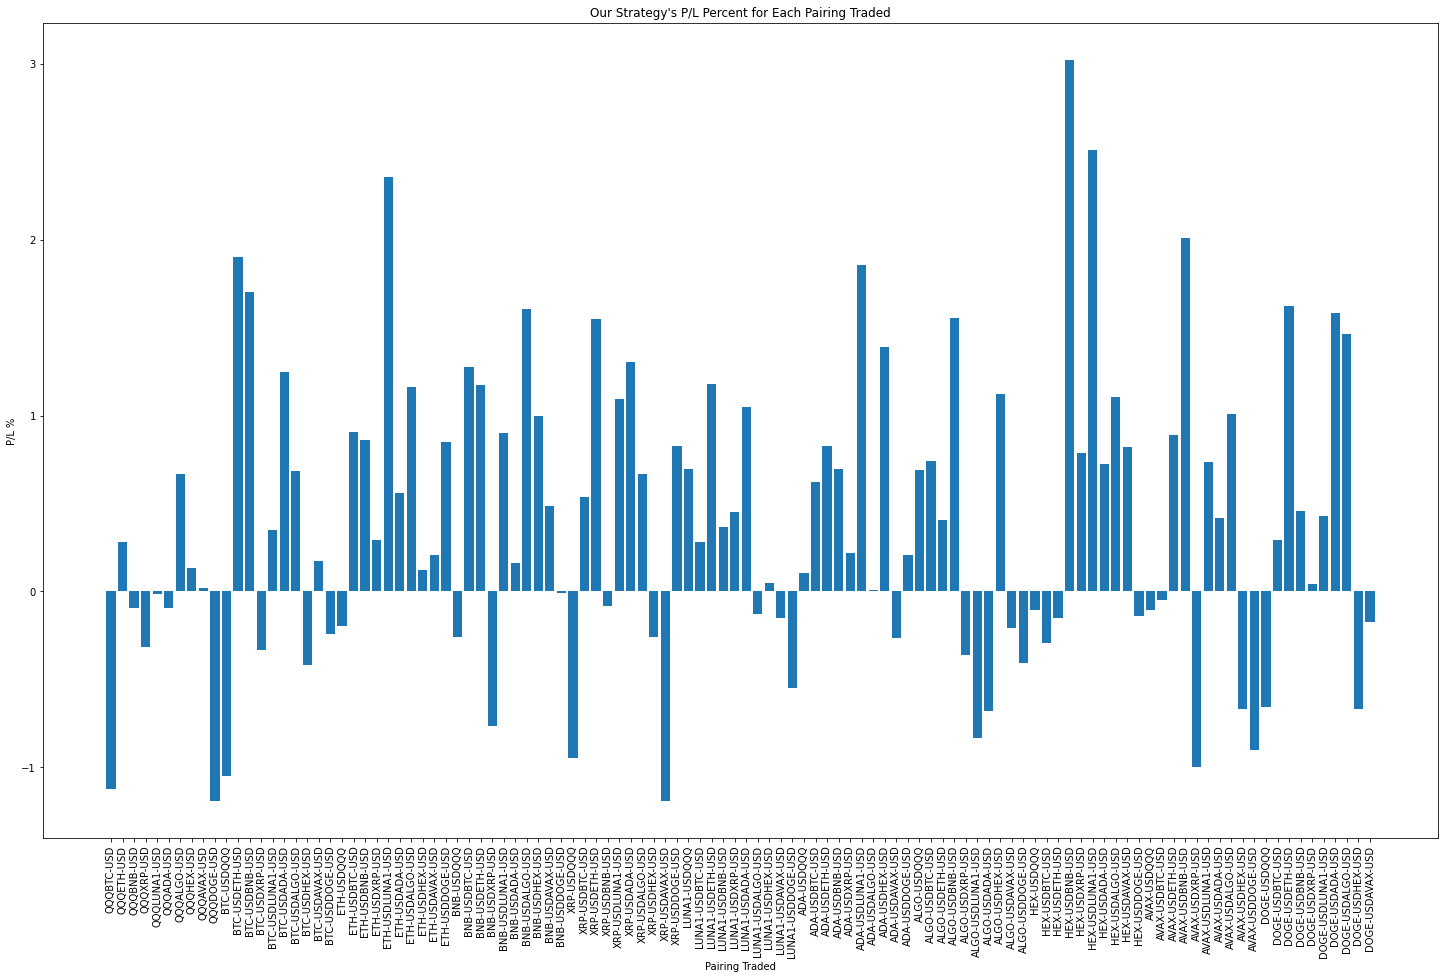

In [69]:
trading_trigger_threshold = 0.01
pair_symbols = offset_matrix.keys()
pnls = []
pnls_dict = {}
trades = []
for pair_symbol in pair_symbols:
    offset = offset_matrix[pair_symbol] 
    diffs = token_diffs[pair_symbol]  
    y1_original, y2_original = y1y2_original[pair_symbol]    
    print(f"Starting {pair_symbol}")
    pnl = 0
    hold = False
    enter_price = 0
    max_timestamp = diffs[-1][1]
    for i in range(len(diffs)-1):
        if diffs[i+1][0] - diffs[i][0] > trading_trigger_threshold and hold is False: # and diffs[i+1][1]+offset < max_timestamp: # buy
            # pnl -= y2_original[diffs[i+1][1]]
            hold = True
            enter_price = y2_original[diffs[i+1][1]]
            print(f"Buy @ {y2_original[diffs[i+1][1]]:.4f} | P/L: {pnl}")
        elif diffs[i][0] - diffs[i+1][0] > trading_trigger_threshold and hold is True: # and diffs[i+1][1]+offset < max_timestamp: # sell
            exit_price = y2_original[diffs[i+1][1]]
            pnl += 100*(exit_price - enter_price) / enter_price
            trades.append(100*(exit_price - enter_price) / enter_price)
            hold = False
            print(f"Sell @ {y2_original[diffs[i+1][1]]:.4f} | P/L: {pnl}")
    if hold:
        exit_price = y2_original[diffs[-1][1]]
        pnl += 100*(exit_price - enter_price) / enter_price
        trades.append(100*(exit_price - enter_price) / enter_price)
        hold = False
        print(f"Sell @ {y2_original[diffs[-1][1]]:.4f} | P/L: {pnl}")
    pnls.append(pnl)
    pnls_dict[pair_symbol] = pnls_dict.get(pair_symbol, 0) + pnl
    print(f"Ending {pair_symbol} | P/L %: {pnl:.2f}")
plt.figure(figsize=(25, 15))
plt.bar(pair_symbols, pnls)
plt.title("Our Strategy's P/L Percent for Each Pairing Traded")
plt.xlabel("Pairing Traded")
plt.ylabel("P/L %")
plt.xticks(rotation='vertical')
plt.show()

In [70]:
inds = np.argsort(-np.array(pnls))
symbs = [*pair_symbols]
for i in range(25):
    ind = inds[i]
    print(f"{symbs[ind]} | {pnls[ind]:.2f}")

HEX-USDBNB-USD | 3.02
HEX-USDLUNA1-USD | 2.51
ETH-USDLUNA1-USD | 2.36
AVAX-USDBNB-USD | 2.01
BTC-USDETH-USD | 1.90
ADA-USDLUNA1-USD | 1.86
BTC-USDBNB-USD | 1.70
DOGE-USDETH-USD | 1.62
BNB-USDALGO-USD | 1.61
DOGE-USDADA-USD | 1.58
ALGO-USDBNB-USD | 1.56
XRP-USDETH-USD | 1.55
DOGE-USDALGO-USD | 1.46
ADA-USDHEX-USD | 1.39
XRP-USDADA-USD | 1.30
BNB-USDBTC-USD | 1.28
BTC-USDADA-USD | 1.25
LUNA1-USDETH-USD | 1.18
BNB-USDETH-USD | 1.18
ETH-USDALGO-USD | 1.17
ALGO-USDHEX-USD | 1.12
HEX-USDALGO-USD | 1.11
XRP-USDLUNA1-USD | 1.10
LUNA1-USDADA-USD | 1.05
AVAX-USDALGO-USD | 1.01


In [71]:
inds = np.argsort(np.array(pnls))
symbs = [*pair_symbols]
for i in range(25):
    ind = inds[i]
    print(f"{symbs[ind]} | {pnls[ind]:.2f}")

XRP-USDAVAX-USD | -1.19
QQQDOGE-USD | -1.19
QQQBTC-USD | -1.12
BTC-USDQQQ | -1.05
AVAX-USDXRP-USD | -1.00
XRP-USDQQQ | -0.94
AVAX-USDDOGE-USD | -0.90
ALGO-USDLUNA1-USD | -0.83
BNB-USDXRP-USD | -0.76
ALGO-USDADA-USD | -0.68
AVAX-USDHEX-USD | -0.67
DOGE-USDHEX-USD | -0.67
DOGE-USDQQQ | -0.66
LUNA1-USDDOGE-USD | -0.55
BTC-USDHEX-USD | -0.42
ALGO-USDDOGE-USD | -0.41
ALGO-USDXRP-USD | -0.36
BTC-USDXRP-USD | -0.33
QQQXRP-USD | -0.32
HEX-USDBTC-USD | -0.29
ADA-USDAVAX-USD | -0.27
XRP-USDHEX-USD | -0.26
BNB-USDQQQ | -0.26
BTC-USDDOGE-USD | -0.24
ALGO-USDAVAX-USD | -0.21


In [72]:
trades = np.array(trades)
wins = trades[trades > 0]
losses = trades[trades < 0]
scratch = trades[trades == 0]

In [73]:
def stats(trades, name):
    def sub_stats(trades, name):
        avg = np.mean(trades)
        sd = np.std(trades)
        print(f"{name} | Avg Trade {avg:.2f}% | SD {sd:.2f}%")
    
    wins = trades[trades > 0]
    losses = trades[trades < 0]
    scratch = trades[trades == 0]
    
    print(f"{name} | Total P/L % :: {np.sum(trades):.2f}%")
    print(f"Winrate {100*len(wins) / (len(trades) - len(scratch)):.2f}% | {len(trades)} Trades, {len(wins)} Winners, {len(losses)} Losers, {len(scratch)} Breakeven")
    sub_stats(trades, "All Trades")
    sub_stats(wins, "Winners")
    sub_stats(losses, "Losers")
    print(f"Profit Factor: {abs(np.sum(wins) / np.sum(losses))} | Gross Profit: {np.sum(wins):.2f}% | Gross Loss: {np.sum(losses):.2f}%")

stats(trades, "All Trades")
    
    

All Trades | Total P/L % :: 44.45%
Winrate 56.40% | 437 Trades, 229 Winners, 177 Losers, 31 Breakeven
All Trades | Avg Trade 0.10% | SD 0.52%
Winners | Avg Trade 0.45% | SD 0.44%
Losers | Avg Trade -0.33% | SD 0.27%
Profit Factor: 1.7557963812847739 | Gross Profit: 103.26% | Gross Loss: -58.81%
